# Accuracy

In [1]:
import sys
sys.path.append("../")
from lib.rs import research_space

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import beta

### LOAD

In [3]:
key = "sjr"

In [4]:
rs_2011 = research_space(key)
rs_2011.load(2011)
rs_2011.set_institution("../../dataset/lattes/pesquisadores.csv", sep=";sep;")
rs_2011.advantages()
rs_2011.set_indicators()

In [5]:
ss_2011 = research_space(key)
ss_2011.load(2011)
ss_2011.load_star_space(200)
ss_2011.set_institution("../../dataset/lattes/pesquisadores.csv", sep=";sep;")
ss_2011.advantages()
ss_2011.set_indicators()

In [6]:
rs_2020 = research_space(key)
rs_2020.load(2020)
rs_2020.set_institution("../../dataset/lattes/pesquisadores.csv", sep=";sep;")
rs_2020.advantages()
rs_2020.set_indicators()

### ACCURACY

In [33]:
def gaussian(ax, x, y, xlab, ylab, title, cmap='coolwarm', comp=False):
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    
    if comp:
        xmin = ymin = 0
        xmax = ymax = 1
    else:
        xmin = min(x) - deltaX
        xmax = max(x) + deltaX
        ymin = min(y) - deltaY
        ymax = max(y) + deltaY
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    if comp:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="darkgrey")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    ax.imshow(np.rot90(f), cmap=cmap, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.title(title)


In [8]:
from collections import defaultdict

sumx = defaultdict(int)
sumi = defaultdict(int)
sume = defaultdict(int)

s = set(rs_2011.scientists)

for sf in rs_2011.x:
    if sf[0] not in s:
        continue

    ins = rs_2011.inst[sf[0]]
    est = rs_2011.est[sf[0]]

    sumi[ins] += rs_2011.x[sf]
    sume[est] += rs_2011.x[sf]
    sumx[sf[0]] += rs_2011.x[sf]
    
sums = [sumx, sumi, sume]

In [39]:
def accuracy(level, transition):
    # Translation
    dic = {x: rs_2020.fields.index(x) for x in rs_2011.fields}
    dic11 = {x: rs_2011.fields.index(x) for x in rs_2011.fields}
    rng = [rs_2011.scientists, set(x[0] for x in rs_2011.rca[1]), set(x[0] for x in rs_2011.rca[2])]
    u = 0 if transition == 'inactive-active' else 1
    
    if level == 'scientist':
        lev = 0
    elif level == 'institution':
        lev = 1
    elif level == 'state':
        lev = 2

    auc = [list(), list()]
    wins = [0,0,0]
    wins_over = [0,0,0]
    spearman = list()
    areas = [list(), list()]
    X = list()
    
    for s in rng[lev]:
        # Prediction
        pred = [0,0]
        pred[0] = rs_2011.predict(s, level, transition)
        pred[1] = ss_2011.predict(s, level, transition)
        rank = [set([x[1] for x in p]) for p in pred]
        
        # Add missing classes
        for i in [0, 1]:
            for j in [x for x in rank[not i] if x not in rank[i]]:
                pred[i].append((0.0, j))
                        
        # Ground truth
        true = [[1 if dic[x[1]] in rs_2020._U[lev][u][s] else 0 for x in p] for p in pred]
        if sum([1 for t in true if sum(t) == 0 or sum(t) == len(t)]) > 0:
            continue
        
        prob = [[x[0] for x in p] for p in pred]
        rank = [[x[1] for x in p] for p in pred]
        
        auc[0].append(roc_auc_score(true[0], prob[0]))
        auc[1].append(roc_auc_score(true[1], prob[1]))
        
        # Summary
        if auc[0][-1] > auc[1][-1]:
            wins[0] += 1
            if auc[1][-1] > 0.5:
                wins_over[0] += 1
        elif auc[0][-1] < auc[1][-1]:
            wins[1] += 1
            if auc[0][-1] > 0.5:
                wins_over[1] += 1
        else:
            wins[2] += 1
            if auc[1][-1] > 0.5:
                wins_over[2] += 1
        
        # Plot data
        n = len(true[0])
        spearman.append(1 - (6*sum((x - rank[1].index(rank[0][x]))**2 for x in range(n)))/(n*(n**2-1)))
        areas[0].append(sum([1 if dic11[x] in rs_2011._U[lev][0][s] else 0 for x in rs_2011.fields]))
        areas[1].append(sum([1 if dic11[x] in rs_2011._U[lev][1][s] else 0 for x in rs_2011.fields]))
        X.append(sums[lev][s])
        
    # Plots
    plt.rcParams["figure.figsize"] = (18,18)
    plt.subplot(3,3,1)
#     fp = dict(marker='o', markersize=5, linestyle='none', alpha=0.01)
#     plt.boxplot(auc, flierprops=fp)
    plt.violinplot(auc, points=60, widths=0.7, showextrema=True, showmedians=True, bw_method=0.5)
    plt.title("{}: {}".format(level, transition))
    plt.ylabel('AUC ROC')
    plt.xticks([1, 2], ['RS', 'SS'])
    
    ax = plt.subplot(3,3,2)
#     plt.hist(spearman, density=True, bins=20)
    pd.DataFrame(spearman).plot(kind='density', ax=ax)
    plt.title("Spearman Correlation Distribution")
    plt.ylabel('Densidade')
    
    ax = plt.subplot(3,3,3)
    gaussian(ax, auc[0], auc[1], "RS", "SS", "Comparação entre previsões", comp=True)
    
    ax = plt.subplot(3,3,4)
    gaussian(ax, areas[0], auc[0], "Número de áreas ativas", "AUC ROC", "Áreas ativas X predição (RS)", 'PuBu')
    ax = plt.subplot(3,3,7)
    gaussian(ax, areas[0], auc[1], "Número de áreas ativas", "AUC ROC", "Áreas ativas X predição (SS)", 'PuBu')
    
    ax = plt.subplot(3,3,5)
    gaussian(ax, areas[1], auc[0], "Número de áreas desenvolvidas", "AUC ROC", "Áreas desenvolvidas X predição (RS)", 'Oranges')
    ax = plt.subplot(3,3,8)
    gaussian(ax, areas[1], auc[1], "Número de áreas desenvolvidas", "AUC ROC", "Áreas desenvolvidas X predição (SS)", 'Oranges')
    
    ax = plt.subplot(3,3,6)
    gaussian(ax, np.log(X), auc[0], "LogNúmero de publicações", "AUC ROC", "LogPublicações e predição (RS)", 'Greens')
    ax = plt.subplot(3,3,9)
    gaussian(ax, np.log(X), auc[1], "LogNúmero de publicações", "AUC ROC", "LogPublicações e predição (SS)", 'Greens')
    
    plt.show()
    
    # print summary
    print("Valor mínimo", [min(x) for x in auc])
    print("Fração menor que 0.5", [sum(1 for x in a if x < 0.5) / len(a) for a in auc])
    print("Fração que foi melhor", [x / sum(wins) for x in wins[:2]])
    print("Fração que foi melhor, acima de 0.5", [x / sum(wins_over) for x in wins_over[:2]])
    print("Médias", [np.mean(x) for x in auc])
    print("Anova:", st.f_oneway(*auc))
    print("Número de amostras:", len(auc[0]))

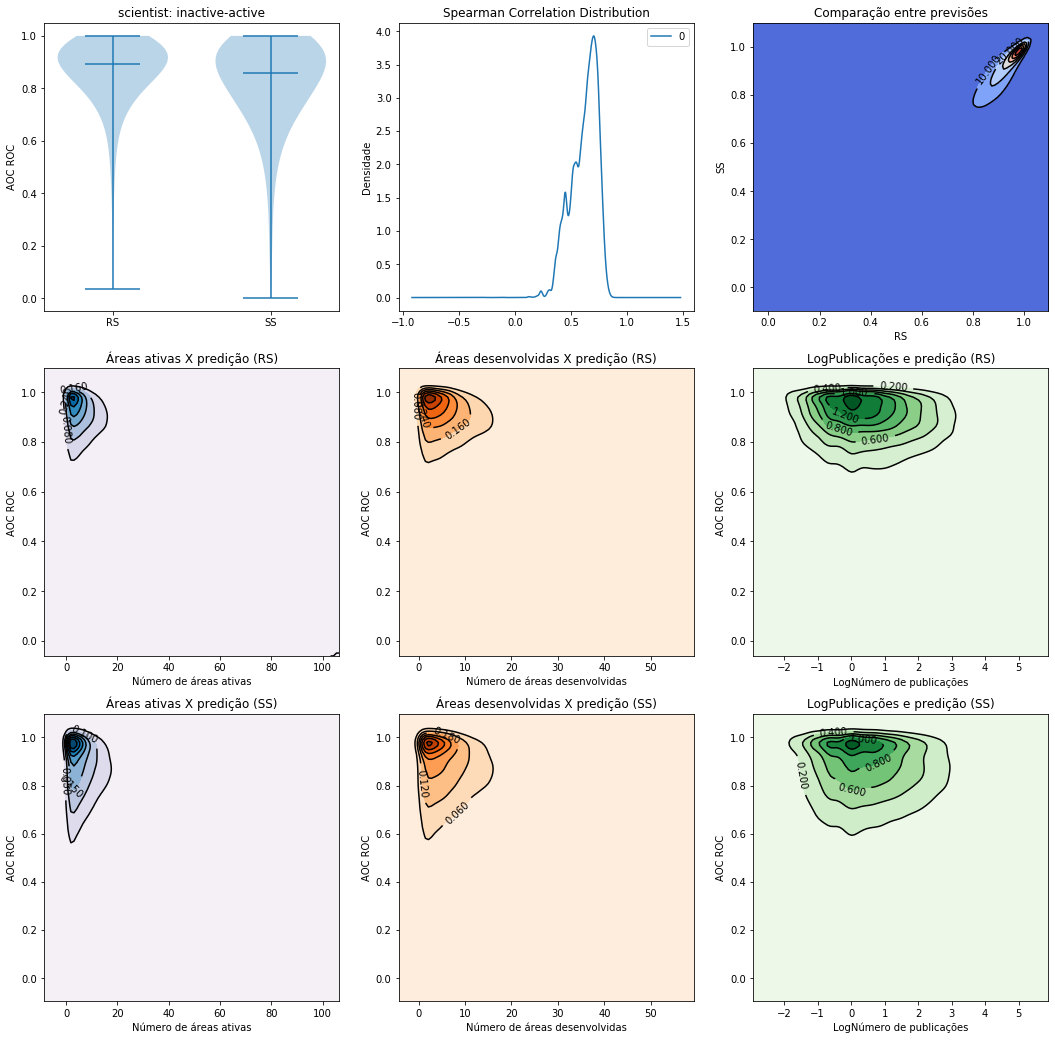

Valor mínimo [0.03610108303249099, 0.0034364261168384758]
Fração menor que 0.5 [0.021794109924128304, 0.04832847330670684]
Fração que foi melhor [0.6395748973866416, 0.34428336488895644]
Fração que foi melhor, acima de 0.5 [0.630023087938744, 0.35292398515357865]


In [10]:
accuracy('scientist', 'inactive-active')

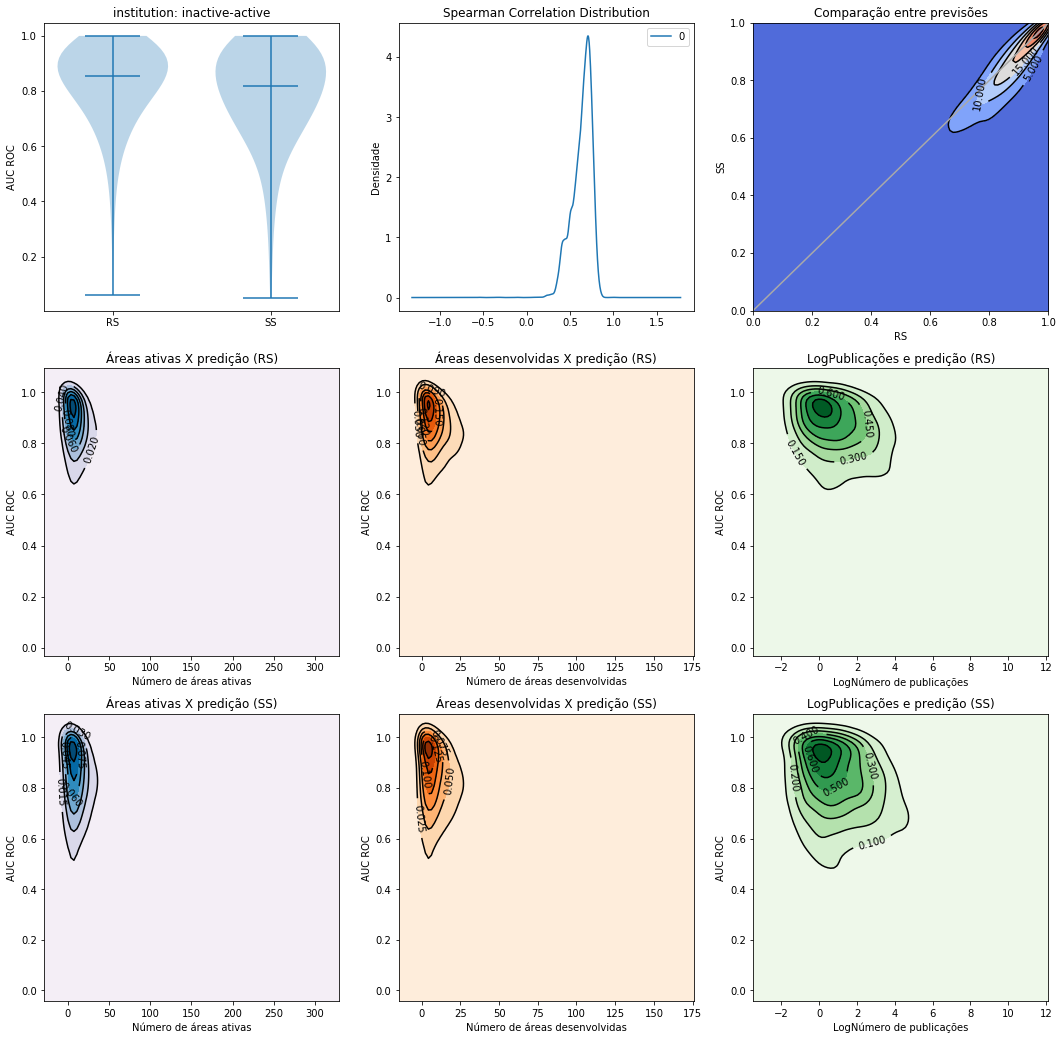

Valor mínimo [0.0625, 0.0515873015873016]
Fração menor que 0.5 [0.035955385970061635, 0.06530672145582624]
Fração que foi melhor [0.6439683005576754, 0.3444379219254476]
Fração que foi melhor, acima de 0.5 [0.6341579448144624, 0.353314303837615]
Médias [0.8243543161110386, 0.7888183023773975]
Anova: F_onewayResult(statistic=174.52439507399464, pvalue=1.331894465552844e-39)
Número de amostras: 6814


In [43]:
accuracy('institution', 'inactive-active')

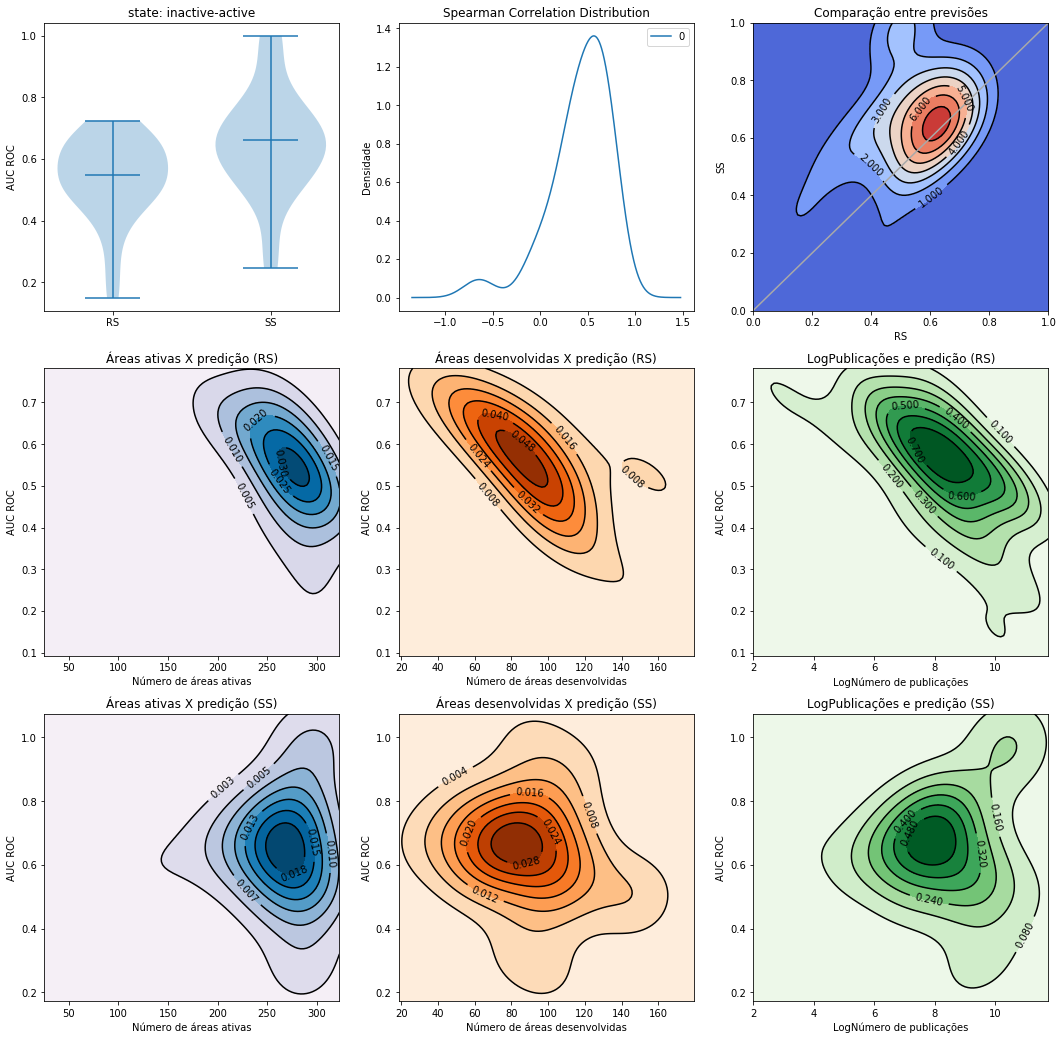

Valor mínimo [0.15000000000000002, 0.24675324675324675]
Fração menor que 0.5 [0.2692307692307692, 0.11538461538461539]
Fração que foi melhor [0.34615384615384615, 0.6538461538461539]
Fração que foi melhor, acima de 0.5 [0.42857142857142855, 0.5714285714285714]
Médias [0.5355312727551993, 0.6523318033968467]
Anova: F_onewayResult(statistic=7.243356503726674, pvalue=0.009652713820656423)
Número de amostras: 26


In [44]:
accuracy('state', 'inactive-active')

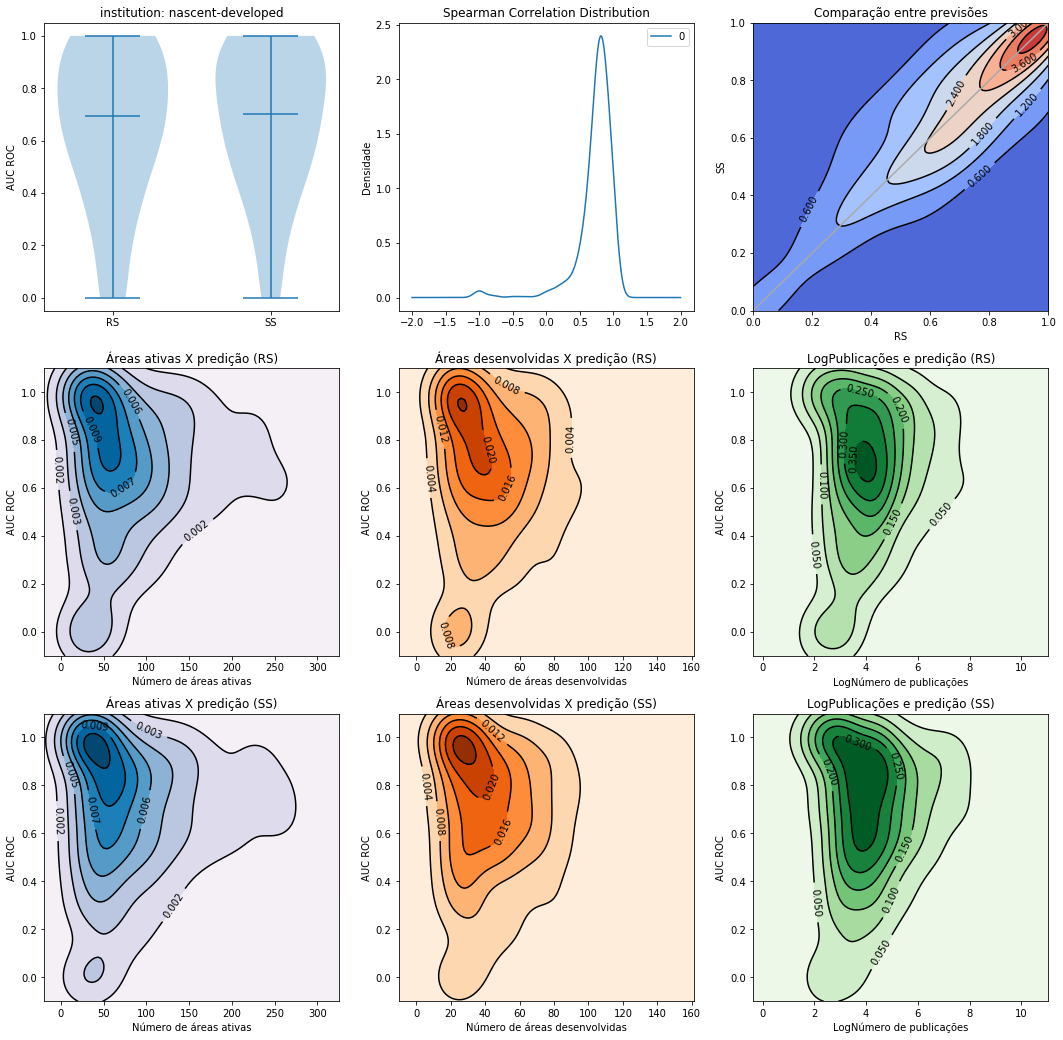

Valor mínimo [0.0, 0.0]
Fração menor que 0.5 [0.26480836236933797, 0.23693379790940766]
Fração que foi melhor [0.38153310104529614, 0.3693379790940767]
Fração que foi melhor, acima de 0.5 [0.4, 0.3277777777777778]
Médias [0.6440926588463339, 0.6654550823430166]
Anova: F_onewayResult(statistic=1.5819554842110997, pvalue=0.20873547228463354)
Número de amostras: 574


In [45]:
accuracy('institution', 'nascent-developed')

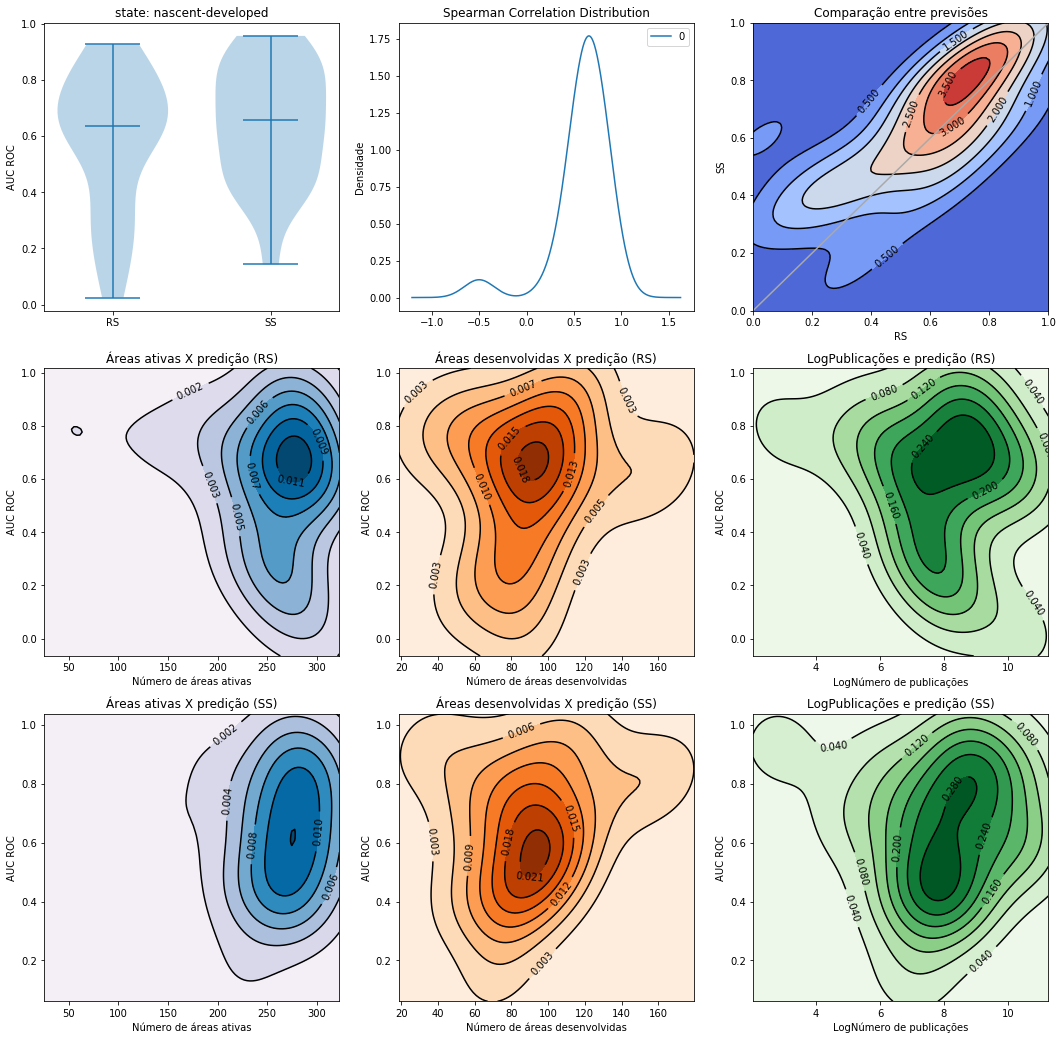

Valor mínimo [0.025000000000000022, 0.14285714285714285]
Fração menor que 0.5 [0.2857142857142857, 0.2857142857142857]
Fração que foi melhor [0.3333333333333333, 0.6666666666666666]
Fração que foi melhor, acima de 0.5 [0.35714285714285715, 0.6428571428571429]
Médias [0.5795575335033417, 0.6404669347130285]
Anova: F_onewayResult(statistic=0.7041524869061033, pvalue=0.4063791065253136)


In [36]:
accuracy('state', 'nascent-developed')

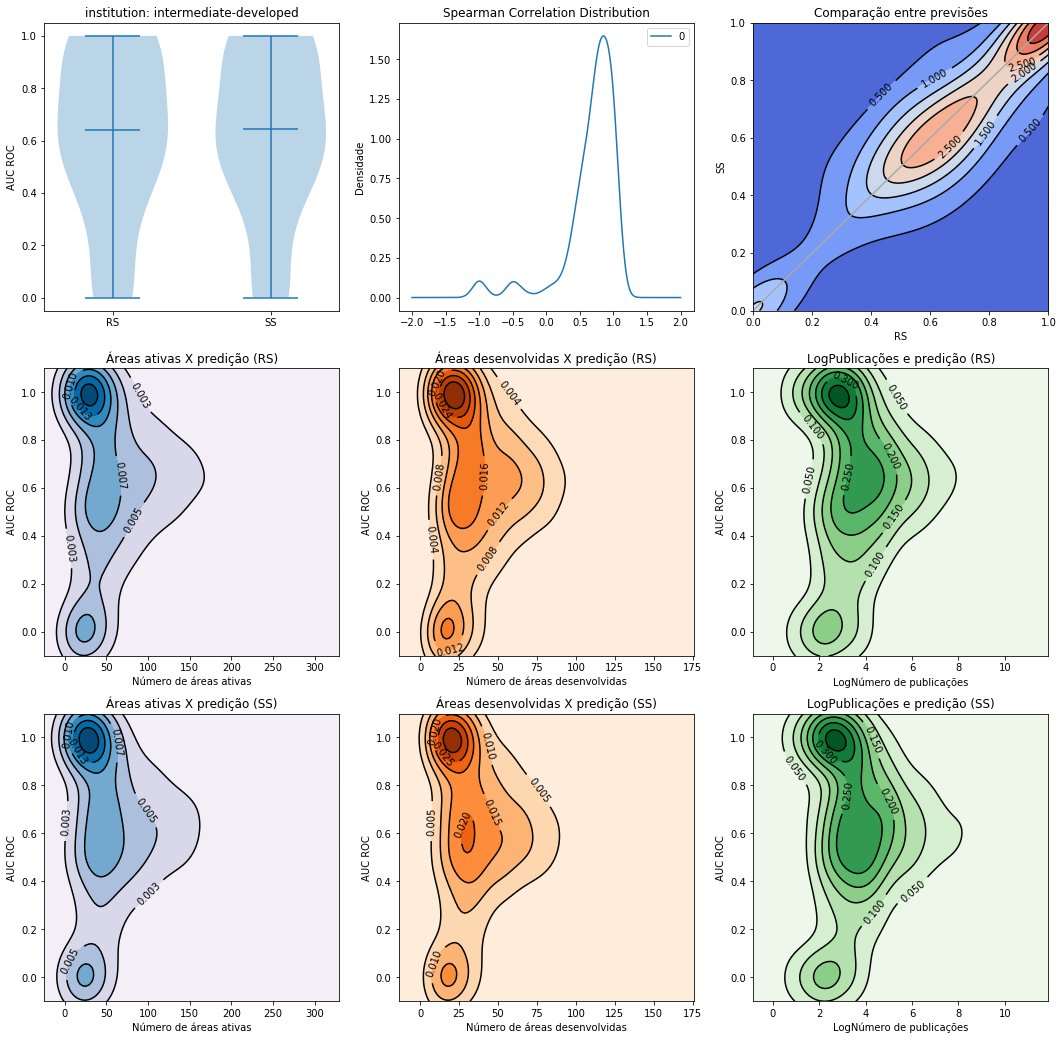

Valor mínimo [0.0, 0.0]
Fração menor que 0.5 [0.28205128205128205, 0.2744539411206078]
Fração que foi melhor [0.35327635327635326, 0.315289648622982]
Fração que foi melhor, acima de 0.5 [0.3435251798561151, 0.25719424460431656]
Médias [0.6113623863612948, 0.6147114884113806]
Anova: F_onewayResult(statistic=0.05812424469074159, pvalue=0.8095090845594822)
Número de amostras: 1053


In [42]:
accuracy('institution', 'intermediate-developed')

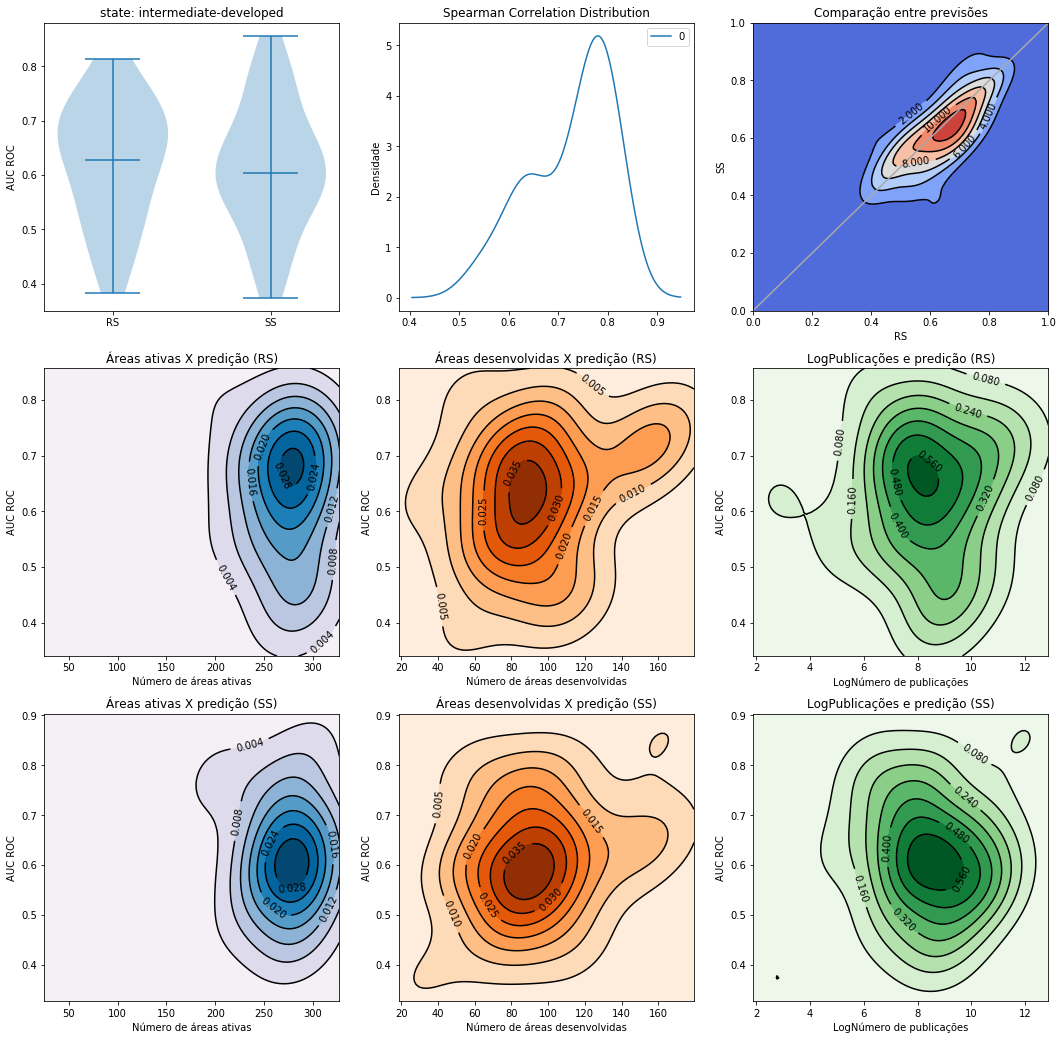

Valor mínimo [0.3835978835978836, 0.375]
Fração menor que 0.5 [0.18518518518518517, 0.18518518518518517]
Fração que foi melhor [0.5925925925925926, 0.4074074074074074]
Fração que foi melhor, acima de 0.5 [0.631578947368421, 0.3684210526315789]
Médias [0.624533326227094, 0.6131477488107776]
Anova: F_onewayResult(statistic=0.13144768796816453, pvalue=0.7184051918042221)
Número de amostras: 27


In [40]:
accuracy('state', 'intermediate-developed')